In [3]:
import os
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# device = torch.device("cpu")
# print(f"Using device: {device}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 示例程序

In [3]:
# 数据集加载

# 定义数据增强操作
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
print(f"训练数据集数量： {len(train_loader.dataset)}")
print(f"测试数据集数量： {len(test_loader.dataset)}")
print(f"训练批次数量： {len(train_loader)}")
print(f"测试批次数量： {len(test_loader)}")

image = next(iter(train_loader))
print('图像通道数/长/宽： ', image[0][0].shape)
print('图像标签样式： ', image[1][0])

训练数据集数量： 60000
测试数据集数量： 10000
训练批次数量： 1875
测试批次数量： 313
图像通道数/长/宽：  torch.Size([1, 28, 28])
图像标签样式：  tensor(9)


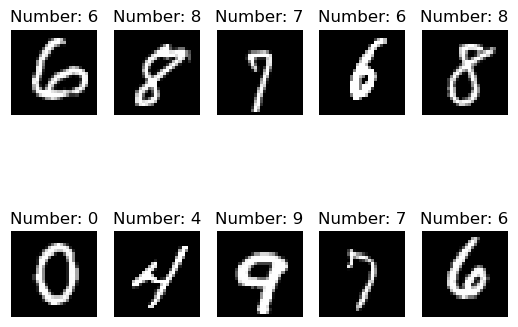

In [5]:
# 显示前10张图片以及对应标签，检查图片是否正确
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Number: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [6]:
# 定义神经网络
class ForwardNN(nn.Module):
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [7]:
# 创建网络、损失函数、优化器
lr = 0.001
num_epoch = 10

net = ForwardNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [8]:
# 检查点保存目录
checkpoint_dir = "./ckpt"
os.makedirs(checkpoint_dir, exist_ok=True)

# 设置保存间隔（每 1875 step / 1 epoch 迭代保存一次）
save_checkpoint_steps = 1875
keep_checkpoint_max = 10
saved_checkpoints = []

In [10]:
print("============== Training Started ==============")

for epoch in range(num_epoch):
    net.train()
    running_loss = 0.0
    start_time = time.time()

    for step, (images, labels) in enumerate(train_loader, 1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 每 save_checkpoint_steps 步保存一次模型
        if step % save_checkpoint_steps == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}_step{step}.pth")
            torch.save(net.state_dict(), checkpoint_path)
            saved_checkpoints.append(checkpoint_path)
            # 保持最多 keep_checkpoint_max 个检查点
            if len(saved_checkpoints) > keep_checkpoint_max:
                os.remove(saved_checkpoints.pop(0))
            print(f"Checkpoint saved at step {step} for epoch {epoch+1}")

    # 每轮次打印损失值和时间
    epoch_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s")

print("============== Training Finished =============")

============== Training Started ==============
Checkpoint saved at step 1875 for epoch 1
Epoch [1/10], Loss: 1.5116, Time: 14.22s
Checkpoint saved at step 1875 for epoch 2
Epoch [2/10], Loss: 1.5112, Time: 13.88s
Checkpoint saved at step 1875 for epoch 3
Epoch [3/10], Loss: 1.5102, Time: 13.55s
Checkpoint saved at step 1875 for epoch 4
Epoch [4/10], Loss: 1.5107, Time: 13.87s
Checkpoint saved at step 1875 for epoch 5
Epoch [5/10], Loss: 1.5121, Time: 13.89s
Checkpoint saved at step 1875 for epoch 6
Epoch [6/10], Loss: 1.5094, Time: 13.97s
Checkpoint saved at step 1875 for epoch 7
Epoch [7/10], Loss: 1.5083, Time: 13.87s
Checkpoint saved at step 1875 for epoch 8
Epoch [8/10], Loss: 1.5078, Time: 13.91s
Checkpoint saved at step 1875 for epoch 9
Epoch [9/10], Loss: 1.5082, Time: 13.85s
Checkpoint saved at step 1875 for epoch 10
Epoch [10/10], Loss: 1.5072, Time: 13.51s
============== Training Finished =============


In [11]:
# 测试模型
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 95.03%


## 调参测试

In [12]:
# 数据集加载
def load_data(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader

In [5]:
# 定义不同模型结构
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

class MediumNN(nn.Module):
    def __init__(self):
        super(MediumNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

In [15]:
# 导入额外的评价指标
from sklearn.metrics import precision_score, recall_score, f1_score

# 定义训练函数
def train_model(model, lr, num_epoch, batch_size, save=False):
    # 加载数据
    train_loader, test_loader = load_data(batch_size)
    
    # 创建网络、损失函数、优化器、记录变量
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    training_records = []
    
    # 训练阶段
    print(f"Started training with model={type(model).__name__}, lr={lr}, num_epoch={num_epoch}, batch_size={batch_size}")
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0      
        start_time = time.time()
        
        for step, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 每 save_checkpoint_steps 步保存一次模型
            if save and step % save_checkpoint_steps == 0:
                checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}_step{step}.pth")
                torch.save(model.state_dict(), checkpoint_path)
                saved_checkpoints.append(checkpoint_path)
                if len(saved_checkpoints) > keep_checkpoint_max:
                    os.remove(saved_checkpoints.pop(0))
                print(f"Checkpoint saved at step {step} for epoch {epoch+1}")
        
        epoch_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s")
        training_records.append({"epoch": epoch+1, "step": step, "loss": epoch_loss, "time": epoch_time})
        
    print(f"Finished training with model={type(model).__name__}, lr={lr}, num_epoch={num_epoch}, batch_size={batch_size}")
    if save:
        training_records_path = os.path.join(checkpoint_dir, "training_records.csv")
        training_records_df = pd.DataFrame(training_records)
        training_records_df.to_csv(training_records_path, index=True)
    
    # 测试阶段
    model.eval()
    all_labels = []
    all_preds = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy on test set: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    return accuracy, precision, recall, f1, epoch_loss

In [14]:
# 输出实验结果
import pandas as pd

# 不同的模型结构列表
models = [SimpleNN, MediumNN, ComplexNN]
# 超参数范围
learning_rates = [0.0001, 0.001, 0.01, 0.1]
num_epochs_list = [2, 5, 10, 15]
batch_sizes = [16, 32, 64, 128]

# 存储实验结果
results = []

# 对每个模型结构进行训练并记录准确率
for model_class in models:
    for lr in learning_rates:
        for num_epoch in num_epochs_list:
            for batch_size in batch_sizes:
                model = model_class()  # 创建不同的模型结构
                accuracy, precision, recall, f1, loss = train_model(model, lr, num_epoch, batch_size)
                results.append({
                    "model": model_class.__name__,
                    "learning_rate": lr,
                    "num_epoch": num_epoch,
                    "batch_size": batch_size,
                    "accuracy": accuracy,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1,
                    "loss": loss
                })
        results_df = pd.DataFrame(results)
        results_df.to_csv('results.csv', index=True)

Started training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=16
Epoch [1/2], Loss: 1.6298, Time: 17.16s
Epoch [2/2], Loss: 1.5541, Time: 17.17s
Finished training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=16
Accuracy on test set: 92.74%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Started training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 1.6663, Time: 14.35s
Epoch [2/2], Loss: 1.5632, Time: 14.53s
Finished training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=32
Accuracy on test set: 92.37%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Started training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 1.7147, Time: 12.78s
Epoch [2/2], Loss: 1.5737, Time: 12.64s
Finished training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=64
Accuracy on test set: 91.99%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Started training with model=SimpleNN, lr=0.0001, num_epoch=2, batch_size=128
Epoch

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 84.34%
Precision: 0.78
Recall: 0.84
F1 Score: 0.80
Started training with model=SimpleNN, lr=0.0001, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 1.6378, Time: 16.84s
Epoch [2/10], Loss: 1.5542, Time: 17.06s
Epoch [3/10], Loss: 1.5374, Time: 16.75s
Epoch [4/10], Loss: 1.5248, Time: 16.85s
Epoch [5/10], Loss: 1.5158, Time: 16.73s
Epoch [6/10], Loss: 1.5085, Time: 17.10s
Epoch [7/10], Loss: 1.5028, Time: 16.81s
Epoch [8/10], Loss: 1.4986, Time: 16.92s
Epoch [9/10], Loss: 1.4947, Time: 16.78s
Epoch [10/10], Loss: 1.4915, Time: 16.93s
Finished training with model=SimpleNN, lr=0.0001, num_epoch=10, batch_size=16
Accuracy on test set: 96.96%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Started training with model=SimpleNN, lr=0.0001, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 1.6664, Time: 14.09s
Epoch [2/10], Loss: 1.5632, Time: 13.94s
Epoch [3/10], Loss: 1.5477, Time: 13.90s
Epoch [4/10], Loss: 1.5361, Time: 13.97s
Epoch [5/10], Loss: 1.5267, Time: 14.08s
Epoch 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 2.3588, Time: 14.27s
Epoch [2/2], Loss: 2.3590, Time: 14.22s
Finished training with model=SimpleNN, lr=0.01, num_epoch=2, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 2.3620, Time: 12.78s
Epoch [2/2], Loss: 2.3620, Time: 12.69s
Finished training with model=SimpleNN, lr=0.01, num_epoch=2, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=2, batch_size=128
Epoch [1/2], Loss: 2.3616, Time: 11.95s
Epoch [2/2], Loss: 2.3624, Time: 11.82s
Finished training with model=SimpleNN, lr=0.01, num_epoch=2, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 2.3590, Time: 17.42s
Epoch [2/5], Loss: 2.3590, Time: 17.21s
Epoch [3/5], Loss: 2.3590, Time: 17.34s
Epoch [4/5], Loss: 2.3590, Time: 17.22s
Epoch [5/5], Loss: 2.3590, Time: 17.32s
Finished training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 2.3626, Time: 14.19s
Epoch [2/5], Loss: 2.3625, Time: 14.44s
Epoch [3/5], Loss: 2.3625, Time: 14.42s
Epoch [4/5], Loss: 2.3625, Time: 14.36s
Epoch [5/5], Loss: 2.3625, Time: 14.13s
Finished training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 2.3568, Time: 12.59s
Epoch [2/5], Loss: 2.3567, Time: 12.60s
Epoch [3/5], Loss: 2.3567, Time: 12.50s
Epoch [4/5], Loss: 2.3567, Time: 12.61s
Epoch [5/5], Loss: 2.3568, Time: 12.44s
Finished training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=128
Epoch [1/5], Loss: 2.2695, Time: 11.90s
Epoch [2/5], Loss: 2.2651, Time: 11.81s
Epoch [3/5], Loss: 2.2618, Time: 11.85s
Epoch [4/5], Loss: 2.2616, Time: 11.72s
Epoch [5/5], Loss: 2.2611, Time: 11.62s
Finished training with model=SimpleNN, lr=0.01, num_epoch=5, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 19.92%
Precision: 0.04
Recall: 0.20
F1 Score: 0.07
Started training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 2.3488, Time: 17.10s
Epoch [2/10], Loss: 2.3488, Time: 16.97s
Epoch [3/10], Loss: 2.3488, Time: 16.92s
Epoch [4/10], Loss: 2.3488, Time: 16.92s
Epoch [5/10], Loss: 2.3488, Time: 17.09s
Epoch [6/10], Loss: 2.3488, Time: 16.90s
Epoch [7/10], Loss: 2.3488, Time: 16.89s
Epoch [8/10], Loss: 2.3488, Time: 16.80s
Epoch [9/10], Loss: 2.3488, Time: 16.95s
Epoch [10/10], Loss: 2.3488, Time: 17.02s
Finished training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 2.3635, Time: 14.02s
Epoch [2/10], Loss: 2.3636, Time: 13.86s
Epoch [3/10], Loss: 2.3636, Time: 14.03s
Epoch [4/10], Loss: 2.3636, Time: 13.87s
Epoch [5/10], Loss: 2.3636, Time: 13.96s
Epoch [6/10], Loss: 2.3636, Time: 13.84s
Epoch [7/10], Loss: 2.3636, Time: 13.99s
Epoch [8/10], Loss: 2.3636, Time: 13.92s
Epoch [9/10], Loss: 2.3636, Time: 13.83s
Epoch [10/10], Loss: 2.3636, Time: 13.70s
Finished training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 2.3620, Time: 12.44s
Epoch [2/10], Loss: 2.3620, Time: 12.51s
Epoch [3/10], Loss: 2.3621, Time: 12.30s
Epoch [4/10], Loss: 2.3620, Time: 12.47s
Epoch [5/10], Loss: 2.3620, Time: 12.40s
Epoch [6/10], Loss: 2.3620, Time: 12.42s
Epoch [7/10], Loss: 2.3621, Time: 12.58s
Epoch [8/10], Loss: 2.3620, Time: 12.52s
Epoch [9/10], Loss: 2.3620, Time: 12.61s
Epoch [10/10], Loss: 2.3620, Time: 12.55s
Finished training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 2.3620, Time: 11.55s
Epoch [2/10], Loss: 2.3624, Time: 11.70s
Epoch [3/10], Loss: 2.3624, Time: 11.55s
Epoch [4/10], Loss: 2.3624, Time: 11.77s
Epoch [5/10], Loss: 2.3624, Time: 11.77s
Epoch [6/10], Loss: 2.3625, Time: 11.63s
Epoch [7/10], Loss: 2.3624, Time: 11.61s
Epoch [8/10], Loss: 2.3624, Time: 11.55s
Epoch [9/10], Loss: 2.3624, Time: 11.54s
Epoch [10/10], Loss: 2.3624, Time: 11.76s
Finished training with model=SimpleNN, lr=0.01, num_epoch=10, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=16
Epoch [1/15], Loss: 2.3625, Time: 16.82s
Epoch [2/15], Loss: 2.3625, Time: 17.01s
Epoch [3/15], Loss: 2.3625, Time: 16.73s
Epoch [4/15], Loss: 2.3625, Time: 17.01s
Epoch [5/15], Loss: 2.3625, Time: 16.97s
Epoch [6/15], Loss: 2.3625, Time: 16.73s
Epoch [7/15], Loss: 2.3625, Time: 16.90s
Epoch [8/15], Loss: 2.3625, Time: 16.93s
Epoch [9/15], Loss: 2.3625, Time: 16.82s
Epoch [10/15], Loss: 2.3625, Time: 16.80s
Epoch [11/15], Loss: 2.3625, Time: 16.98s
Epoch [12/15], Loss: 2.3625, Time: 16.87s
Epoch [13/15], Loss: 2.3625, Time: 16.88s
Epoch [14/15], Loss: 2.3625, Time: 17.03s
Epoch [15/15], Loss: 2.3625, Time: 17.25s
Finished training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 2.3637, Time: 13.82s
Epoch [2/15], Loss: 2.3636, Time: 13.95s
Epoch [3/15], Loss: 2.3636, Time: 13.99s
Epoch [4/15], Loss: 2.3636, Time: 14.09s
Epoch [5/15], Loss: 2.3636, Time: 13.86s
Epoch [6/15], Loss: 2.3636, Time: 13.92s
Epoch [7/15], Loss: 2.3636, Time: 13.71s
Epoch [8/15], Loss: 2.3636, Time: 13.85s
Epoch [9/15], Loss: 2.3636, Time: 13.85s
Epoch [10/15], Loss: 2.3636, Time: 13.80s
Epoch [11/15], Loss: 2.3636, Time: 13.89s
Epoch [12/15], Loss: 2.3636, Time: 13.99s
Epoch [13/15], Loss: 2.3636, Time: 13.98s
Epoch [14/15], Loss: 2.3636, Time: 13.75s
Epoch [15/15], Loss: 2.3636, Time: 13.91s
Finished training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 2.3619, Time: 12.26s
Epoch [2/15], Loss: 2.3620, Time: 12.43s
Epoch [3/15], Loss: 2.3620, Time: 12.47s
Epoch [4/15], Loss: 2.3620, Time: 12.40s
Epoch [5/15], Loss: 2.3619, Time: 12.38s
Epoch [6/15], Loss: 2.3620, Time: 12.36s
Epoch [7/15], Loss: 2.3620, Time: 12.55s
Epoch [8/15], Loss: 2.3620, Time: 12.53s
Epoch [9/15], Loss: 2.3620, Time: 12.38s
Epoch [10/15], Loss: 2.3620, Time: 12.33s
Epoch [11/15], Loss: 2.3620, Time: 12.27s
Epoch [12/15], Loss: 2.3620, Time: 12.47s
Epoch [13/15], Loss: 2.3620, Time: 12.37s
Epoch [14/15], Loss: 2.3620, Time: 12.30s
Epoch [15/15], Loss: 2.3620, Time: 12.42s
Finished training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=128
Epoch [1/15], Loss: 2.2718, Time: 11.55s
Epoch [2/15], Loss: 2.2702, Time: 11.59s
Epoch [3/15], Loss: 2.2760, Time: 11.65s
Epoch [4/15], Loss: 2.2735, Time: 11.51s
Epoch [5/15], Loss: 2.2697, Time: 11.49s
Epoch [6/15], Loss: 2.2695, Time: 11.71s
Epoch [7/15], Loss: 2.2733, Time: 11.53s
Epoch [8/15], Loss: 2.2830, Time: 11.42s
Epoch [9/15], Loss: 2.2749, Time: 11.48s
Epoch [10/15], Loss: 2.3093, Time: 11.31s
Epoch [11/15], Loss: 2.2741, Time: 11.41s
Epoch [12/15], Loss: 2.2700, Time: 11.34s
Epoch [13/15], Loss: 2.2746, Time: 11.30s
Epoch [14/15], Loss: 2.2674, Time: 11.47s
Epoch [15/15], Loss: 2.2858, Time: 11.30s
Finished training with model=SimpleNN, lr=0.01, num_epoch=15, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 18.53%
Precision: 0.05
Recall: 0.19
F1 Score: 0.07
Started training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=16
Epoch [1/2], Loss: 2.3619, Time: 16.65s
Epoch [2/2], Loss: 2.3619, Time: 16.73s
Finished training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 2.3568, Time: 13.89s
Epoch [2/2], Loss: 2.3567, Time: 13.48s
Finished training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 2.3620, Time: 11.96s
Epoch [2/2], Loss: 2.3618, Time: 11.96s
Finished training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=128
Epoch [1/2], Loss: 2.3636, Time: 11.13s
Epoch [2/2], Loss: 2.3637, Time: 11.53s
Finished training with model=SimpleNN, lr=0.1, num_epoch=2, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 2.3637, Time: 16.72s
Epoch [2/5], Loss: 2.3636, Time: 16.95s
Epoch [3/5], Loss: 2.3636, Time: 16.68s
Epoch [4/5], Loss: 2.3636, Time: 16.85s
Epoch [5/5], Loss: 2.3636, Time: 16.78s
Finished training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 2.3639, Time: 13.74s
Epoch [2/5], Loss: 2.3638, Time: 13.73s
Epoch [3/5], Loss: 2.3638, Time: 13.73s
Epoch [4/5], Loss: 2.3638, Time: 13.73s
Epoch [5/5], Loss: 2.3638, Time: 13.68s
Finished training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.82%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 2.3619, Time: 12.03s
Epoch [2/5], Loss: 2.3618, Time: 12.20s
Epoch [3/5], Loss: 2.3619, Time: 12.07s
Epoch [4/5], Loss: 2.3618, Time: 12.28s
Epoch [5/5], Loss: 2.3619, Time: 12.10s
Finished training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=128
Epoch [1/5], Loss: 2.3567, Time: 11.34s
Epoch [2/5], Loss: 2.3567, Time: 11.26s
Epoch [3/5], Loss: 2.3568, Time: 11.31s
Epoch [4/5], Loss: 2.3567, Time: 11.29s
Epoch [5/5], Loss: 2.3568, Time: 11.34s
Finished training with model=SimpleNN, lr=0.1, num_epoch=5, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 2.3626, Time: 16.73s
Epoch [2/10], Loss: 2.3625, Time: 16.84s
Epoch [3/10], Loss: 2.3625, Time: 16.82s
Epoch [4/10], Loss: 2.3625, Time: 16.88s
Epoch [5/10], Loss: 2.3625, Time: 16.76s
Epoch [6/10], Loss: 2.3625, Time: 16.88s
Epoch [7/10], Loss: 2.3625, Time: 16.68s
Epoch [8/10], Loss: 2.3625, Time: 16.77s
Epoch [9/10], Loss: 2.3625, Time: 16.76s
Epoch [10/10], Loss: 2.3625, Time: 16.80s
Finished training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 2.3625, Time: 13.61s
Epoch [2/10], Loss: 2.3624, Time: 13.71s
Epoch [3/10], Loss: 2.3624, Time: 13.71s
Epoch [4/10], Loss: 2.3624, Time: 13.77s
Epoch [5/10], Loss: 2.3624, Time: 13.67s
Epoch [6/10], Loss: 2.3624, Time: 13.80s
Epoch [7/10], Loss: 2.3624, Time: 13.65s
Epoch [8/10], Loss: 2.3624, Time: 13.72s
Epoch [9/10], Loss: 2.3624, Time: 13.80s
Epoch [10/10], Loss: 2.3624, Time: 13.65s
Finished training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 2.3707, Time: 12.18s
Epoch [2/10], Loss: 2.3708, Time: 12.15s
Epoch [3/10], Loss: 2.3708, Time: 12.22s
Epoch [4/10], Loss: 2.3707, Time: 12.18s
Epoch [5/10], Loss: 2.3708, Time: 12.06s
Epoch [6/10], Loss: 2.3708, Time: 12.23s
Epoch [7/10], Loss: 2.3708, Time: 12.08s
Epoch [8/10], Loss: 2.3708, Time: 12.26s
Epoch [9/10], Loss: 2.3708, Time: 12.13s
Epoch [10/10], Loss: 2.3708, Time: 12.06s
Finished training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 2.3624, Time: 11.27s
Epoch [2/10], Loss: 2.3624, Time: 11.24s
Epoch [3/10], Loss: 2.3624, Time: 11.30s
Epoch [4/10], Loss: 2.3625, Time: 11.44s
Epoch [5/10], Loss: 2.3625, Time: 11.34s
Epoch [6/10], Loss: 2.3624, Time: 11.20s
Epoch [7/10], Loss: 2.3625, Time: 11.35s
Epoch [8/10], Loss: 2.3624, Time: 11.33s
Epoch [9/10], Loss: 2.3624, Time: 11.40s
Epoch [10/10], Loss: 2.3624, Time: 11.19s
Finished training with model=SimpleNN, lr=0.1, num_epoch=10, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=16
Epoch [1/15], Loss: 2.3611, Time: 16.80s
Epoch [2/15], Loss: 2.3590, Time: 16.89s
Epoch [3/15], Loss: 2.3590, Time: 16.73s
Epoch [4/15], Loss: 2.3590, Time: 16.71s
Epoch [5/15], Loss: 2.3590, Time: 16.72s
Epoch [6/15], Loss: 2.3590, Time: 16.61s
Epoch [7/15], Loss: 2.3590, Time: 16.78s
Epoch [8/15], Loss: 2.3590, Time: 16.58s
Epoch [9/15], Loss: 2.3590, Time: 16.76s
Epoch [10/15], Loss: 2.3590, Time: 16.90s
Epoch [11/15], Loss: 2.3590, Time: 16.80s
Epoch [12/15], Loss: 2.3590, Time: 16.51s
Epoch [13/15], Loss: 2.3590, Time: 16.78s
Epoch [14/15], Loss: 2.3590, Time: 16.68s
Epoch [15/15], Loss: 2.3590, Time: 16.68s
Finished training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 2.3489, Time: 13.56s
Epoch [2/15], Loss: 2.3488, Time: 13.73s
Epoch [3/15], Loss: 2.3488, Time: 13.56s
Epoch [4/15], Loss: 2.3488, Time: 13.66s
Epoch [5/15], Loss: 2.3488, Time: 13.62s
Epoch [6/15], Loss: 2.3488, Time: 14.05s
Epoch [7/15], Loss: 2.3488, Time: 13.62s
Epoch [8/15], Loss: 2.3488, Time: 13.45s
Epoch [9/15], Loss: 2.3488, Time: 13.67s
Epoch [10/15], Loss: 2.3488, Time: 13.56s
Epoch [11/15], Loss: 2.3488, Time: 13.68s
Epoch [12/15], Loss: 2.3488, Time: 13.58s
Epoch [13/15], Loss: 2.3488, Time: 13.57s
Epoch [14/15], Loss: 2.3488, Time: 13.56s
Epoch [15/15], Loss: 2.3488, Time: 13.67s
Finished training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 2.3619, Time: 11.94s
Epoch [2/15], Loss: 2.3619, Time: 12.09s
Epoch [3/15], Loss: 2.3619, Time: 12.14s
Epoch [4/15], Loss: 2.3618, Time: 12.03s
Epoch [5/15], Loss: 2.3619, Time: 12.09s
Epoch [6/15], Loss: 2.3619, Time: 12.19s
Epoch [7/15], Loss: 2.3618, Time: 12.12s
Epoch [8/15], Loss: 2.3618, Time: 12.13s
Epoch [9/15], Loss: 2.3618, Time: 12.10s
Epoch [10/15], Loss: 2.3618, Time: 12.04s
Epoch [11/15], Loss: 2.3618, Time: 12.08s
Epoch [12/15], Loss: 2.3619, Time: 12.11s
Epoch [13/15], Loss: 2.3618, Time: 12.19s
Epoch [14/15], Loss: 2.3619, Time: 12.12s
Epoch [15/15], Loss: 2.3618, Time: 12.03s
Finished training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=128
Epoch [1/15], Loss: 2.3624, Time: 11.43s
Epoch [2/15], Loss: 2.3624, Time: 11.27s
Epoch [3/15], Loss: 2.3624, Time: 11.28s
Epoch [4/15], Loss: 2.3624, Time: 11.29s
Epoch [5/15], Loss: 2.3624, Time: 11.44s
Epoch [6/15], Loss: 2.3624, Time: 11.33s
Epoch [7/15], Loss: 2.3625, Time: 11.25s
Epoch [8/15], Loss: 2.3625, Time: 11.30s
Epoch [9/15], Loss: 2.3624, Time: 11.33s
Epoch [10/15], Loss: 2.3624, Time: 11.26s
Epoch [11/15], Loss: 2.3624, Time: 11.19s
Epoch [12/15], Loss: 2.3624, Time: 11.34s
Epoch [13/15], Loss: 2.3624, Time: 11.24s
Epoch [14/15], Loss: 2.3624, Time: 11.18s
Epoch [15/15], Loss: 2.3625, Time: 11.25s
Finished training with model=SimpleNN, lr=0.1, num_epoch=15, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.0001, num_epoch=2, batch_size=16
Epoch [1/2], Loss: 1.6243, Time: 17.46s
Epoch [2/2], Loss: 1.5451, Time: 17.49s
Finished training with model=MediumNN, lr=0.0001, num_epoch=2, batch_size=16
Accuracy on test set: 93.42%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Started training with model=MediumNN, lr=0.0001, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 1.6432, Time: 14.06s
Epoch [2/2], Loss: 1.5512, Time: 14.27s
Finished training with model=MediumNN, lr=0.0001, num_epoch=2, batch_size=32
Accuracy on test set: 92.24%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Started training with model=MediumNN, lr=0.0001, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 1.6925, Time: 12.22s
Epoch [2/2], Loss: 1.5621, Time: 12.30s
Finished training with model=MediumNN, lr=0.0001, num_epoch=2, batch_size=64
Accuracy on test set: 92.17%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Started tr

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 84.95%
Precision: 0.78
Recall: 0.85
F1 Score: 0.81
Started training with model=MediumNN, lr=0.0001, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 1.6356, Time: 17.43s
Epoch [2/5], Loss: 1.5464, Time: 17.63s
Epoch [3/5], Loss: 1.5274, Time: 17.46s
Epoch [4/5], Loss: 1.5154, Time: 17.59s
Epoch [5/5], Loss: 1.5069, Time: 17.32s
Finished training with model=MediumNN, lr=0.0001, num_epoch=5, batch_size=16
Accuracy on test set: 95.68%
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Started training with model=MediumNN, lr=0.0001, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 1.6430, Time: 14.08s
Epoch [2/5], Loss: 1.5544, Time: 13.99s
Epoch [3/5], Loss: 1.5380, Time: 14.22s
Epoch [4/5], Loss: 1.5264, Time: 14.00s
Epoch [5/5], Loss: 1.5178, Time: 14.10s
Finished training with model=MediumNN, lr=0.0001, num_epoch=5, batch_size=32
Accuracy on test set: 94.96%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Started training with model=MediumNN, lr=0.0001, num_epoch=5, batch_size=64

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 2.3615, Time: 14.24s
Epoch [2/2], Loss: 2.3619, Time: 14.12s
Finished training with model=MediumNN, lr=0.01, num_epoch=2, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 2.3707, Time: 12.42s
Epoch [2/2], Loss: 2.3708, Time: 12.50s
Finished training with model=MediumNN, lr=0.01, num_epoch=2, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=MediumNN, lr=0.01, num_epoch=2, batch_size=128
Epoch [1/2], Loss: 2.3488, Time: 11.46s
Epoch [2/2], Loss: 2.3488, Time: 11.55s
Finished training with model=MediumNN, lr=0.01, num_epoch=2, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 2.3620, Time: 17.61s
Epoch [2/5], Loss: 2.3620, Time: 17.70s
Epoch [3/5], Loss: 2.3620, Time: 17.58s
Epoch [4/5], Loss: 2.3620, Time: 17.65s
Epoch [5/5], Loss: 2.3620, Time: 17.73s
Finished training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 2.3489, Time: 14.35s
Epoch [2/5], Loss: 2.3488, Time: 14.26s
Epoch [3/5], Loss: 2.3488, Time: 14.33s
Epoch [4/5], Loss: 2.3488, Time: 14.16s
Epoch [5/5], Loss: 2.3488, Time: 14.24s
Finished training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 2.3488, Time: 12.44s
Epoch [2/5], Loss: 2.3488, Time: 12.66s
Epoch [3/5], Loss: 2.3488, Time: 12.48s
Epoch [4/5], Loss: 2.3488, Time: 12.44s
Epoch [5/5], Loss: 2.3487, Time: 12.56s
Finished training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=128
Epoch [1/5], Loss: 2.3588, Time: 11.49s
Epoch [2/5], Loss: 2.3589, Time: 11.65s
Epoch [3/5], Loss: 2.3589, Time: 11.46s
Epoch [4/5], Loss: 2.3590, Time: 11.58s
Epoch [5/5], Loss: 2.3590, Time: 11.62s
Finished training with model=MediumNN, lr=0.01, num_epoch=5, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 2.3620, Time: 17.69s
Epoch [2/10], Loss: 2.3620, Time: 17.91s
Epoch [3/10], Loss: 2.3620, Time: 17.61s
Epoch [4/10], Loss: 2.3620, Time: 17.70s
Epoch [5/10], Loss: 2.3620, Time: 17.83s
Epoch [6/10], Loss: 2.3620, Time: 17.79s
Epoch [7/10], Loss: 2.3620, Time: 17.81s
Epoch [8/10], Loss: 2.3620, Time: 17.82s
Epoch [9/10], Loss: 2.3620, Time: 17.69s
Epoch [10/10], Loss: 2.3620, Time: 17.56s
Finished training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 2.3621, Time: 14.23s
Epoch [2/10], Loss: 2.3620, Time: 14.30s
Epoch [3/10], Loss: 2.3620, Time: 14.22s
Epoch [4/10], Loss: 2.3620, Time: 14.14s
Epoch [5/10], Loss: 2.3620, Time: 14.20s
Epoch [6/10], Loss: 2.3620, Time: 14.18s
Epoch [7/10], Loss: 2.3620, Time: 14.17s
Epoch [8/10], Loss: 2.3620, Time: 14.01s
Epoch [9/10], Loss: 2.3620, Time: 14.29s
Epoch [10/10], Loss: 2.3620, Time: 14.11s
Finished training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 2.3639, Time: 12.39s
Epoch [2/10], Loss: 2.3638, Time: 12.57s
Epoch [3/10], Loss: 2.3638, Time: 12.53s
Epoch [4/10], Loss: 2.3638, Time: 12.65s
Epoch [5/10], Loss: 2.3638, Time: 12.54s
Epoch [6/10], Loss: 2.3638, Time: 12.48s
Epoch [7/10], Loss: 2.3638, Time: 12.69s
Epoch [8/10], Loss: 2.3638, Time: 12.53s
Epoch [9/10], Loss: 2.3638, Time: 12.58s
Epoch [10/10], Loss: 2.3638, Time: 12.43s
Finished training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.82%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 2.3621, Time: 11.62s
Epoch [2/10], Loss: 2.3625, Time: 11.62s
Epoch [3/10], Loss: 2.3625, Time: 11.47s
Epoch [4/10], Loss: 2.3625, Time: 11.48s
Epoch [5/10], Loss: 2.3625, Time: 11.51s
Epoch [6/10], Loss: 2.3625, Time: 11.43s
Epoch [7/10], Loss: 2.3625, Time: 11.62s
Epoch [8/10], Loss: 2.3625, Time: 11.56s
Epoch [9/10], Loss: 2.3625, Time: 11.64s
Epoch [10/10], Loss: 2.3625, Time: 11.67s
Finished training with model=MediumNN, lr=0.01, num_epoch=10, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=16
Epoch [1/15], Loss: 2.3620, Time: 17.53s
Epoch [2/15], Loss: 2.3620, Time: 17.70s
Epoch [3/15], Loss: 2.3620, Time: 17.81s
Epoch [4/15], Loss: 2.3620, Time: 17.65s
Epoch [5/15], Loss: 2.3620, Time: 17.81s
Epoch [6/15], Loss: 2.3620, Time: 17.67s
Epoch [7/15], Loss: 2.3620, Time: 17.77s
Epoch [8/15], Loss: 2.3620, Time: 17.70s
Epoch [9/15], Loss: 2.3620, Time: 17.67s
Epoch [10/15], Loss: 2.3620, Time: 17.72s
Epoch [11/15], Loss: 2.3620, Time: 17.53s
Epoch [12/15], Loss: 2.3620, Time: 17.47s
Epoch [13/15], Loss: 2.3620, Time: 17.58s
Epoch [14/15], Loss: 2.3620, Time: 17.56s
Epoch [15/15], Loss: 2.3620, Time: 17.65s
Finished training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 2.3488, Time: 14.10s
Epoch [2/15], Loss: 2.3488, Time: 14.13s
Epoch [3/15], Loss: 2.3488, Time: 14.12s
Epoch [4/15], Loss: 2.3488, Time: 14.28s
Epoch [5/15], Loss: 2.3488, Time: 15.16s
Epoch [6/15], Loss: 2.3488, Time: 14.53s
Epoch [7/15], Loss: 2.3488, Time: 14.53s
Epoch [8/15], Loss: 2.3488, Time: 14.74s
Epoch [9/15], Loss: 2.3488, Time: 14.72s
Epoch [10/15], Loss: 2.3488, Time: 14.81s
Epoch [11/15], Loss: 2.3488, Time: 14.69s
Epoch [12/15], Loss: 2.3488, Time: 14.71s
Epoch [13/15], Loss: 2.3488, Time: 14.46s
Epoch [14/15], Loss: 2.3488, Time: 14.73s
Epoch [15/15], Loss: 2.3488, Time: 14.35s
Finished training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 2.3617, Time: 12.62s
Epoch [2/15], Loss: 2.3619, Time: 12.65s
Epoch [3/15], Loss: 2.3619, Time: 12.57s
Epoch [4/15], Loss: 2.3618, Time: 12.73s
Epoch [5/15], Loss: 2.3619, Time: 12.42s
Epoch [6/15], Loss: 2.3619, Time: 12.56s
Epoch [7/15], Loss: 2.3618, Time: 12.67s
Epoch [8/15], Loss: 2.3619, Time: 12.65s
Epoch [9/15], Loss: 2.3619, Time: 12.71s
Epoch [10/15], Loss: 2.3618, Time: 12.66s
Epoch [11/15], Loss: 2.3618, Time: 12.86s
Epoch [12/15], Loss: 2.3618, Time: 12.69s
Epoch [13/15], Loss: 2.3619, Time: 12.76s
Epoch [14/15], Loss: 2.3618, Time: 13.04s
Epoch [15/15], Loss: 2.3619, Time: 12.80s
Finished training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=128
Epoch [1/15], Loss: 2.3569, Time: 11.95s
Epoch [2/15], Loss: 2.3568, Time: 11.77s
Epoch [3/15], Loss: 2.3567, Time: 11.92s
Epoch [4/15], Loss: 2.3567, Time: 12.07s
Epoch [5/15], Loss: 2.3567, Time: 11.97s
Epoch [6/15], Loss: 2.3567, Time: 12.30s
Epoch [7/15], Loss: 2.3568, Time: 12.14s
Epoch [8/15], Loss: 2.3567, Time: 12.27s
Epoch [9/15], Loss: 2.3567, Time: 12.13s
Epoch [10/15], Loss: 2.3568, Time: 11.82s
Epoch [11/15], Loss: 2.3567, Time: 11.86s
Epoch [12/15], Loss: 2.3567, Time: 11.96s
Epoch [13/15], Loss: 2.3567, Time: 11.95s
Epoch [14/15], Loss: 2.3567, Time: 12.10s
Epoch [15/15], Loss: 2.3567, Time: 11.97s
Finished training with model=MediumNN, lr=0.01, num_epoch=15, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=16
Epoch [1/2], Loss: 2.3620, Time: 18.39s
Epoch [2/2], Loss: 2.3620, Time: 18.32s
Finished training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 2.3637, Time: 14.83s
Epoch [2/2], Loss: 2.3636, Time: 14.87s
Finished training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 2.3625, Time: 13.11s
Epoch [2/2], Loss: 2.3625, Time: 13.05s
Finished training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=128
Epoch [1/2], Loss: 2.3618, Time: 12.15s
Epoch [2/2], Loss: 2.3619, Time: 12.07s
Finished training with model=MediumNN, lr=0.1, num_epoch=2, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.32%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 2.3624, Time: 18.33s
Epoch [2/5], Loss: 2.3624, Time: 18.33s
Epoch [3/5], Loss: 2.3624, Time: 18.15s
Epoch [4/5], Loss: 2.3624, Time: 17.98s
Epoch [5/5], Loss: 2.3624, Time: 18.12s
Finished training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 2.3620, Time: 14.86s
Epoch [2/5], Loss: 2.3620, Time: 14.53s
Epoch [3/5], Loss: 2.3620, Time: 14.41s
Epoch [4/5], Loss: 2.3620, Time: 14.40s
Epoch [5/5], Loss: 2.3620, Time: 14.19s
Finished training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 2.3625, Time: 12.54s
Epoch [2/5], Loss: 2.3625, Time: 12.54s
Epoch [3/5], Loss: 2.3625, Time: 12.70s
Epoch [4/5], Loss: 2.3625, Time: 12.66s
Epoch [5/5], Loss: 2.3625, Time: 12.71s
Finished training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=128
Epoch [1/5], Loss: 2.3636, Time: 11.70s
Epoch [2/5], Loss: 2.3636, Time: 11.61s
Epoch [3/5], Loss: 2.3636, Time: 11.73s
Epoch [4/5], Loss: 2.3636, Time: 11.59s
Epoch [5/5], Loss: 2.3636, Time: 11.55s
Finished training with model=MediumNN, lr=0.1, num_epoch=5, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 2.3638, Time: 17.82s
Epoch [2/10], Loss: 2.3638, Time: 17.80s
Epoch [3/10], Loss: 2.3638, Time: 17.57s
Epoch [4/10], Loss: 2.3638, Time: 17.69s
Epoch [5/10], Loss: 2.3638, Time: 17.62s
Epoch [6/10], Loss: 2.3638, Time: 17.94s
Epoch [7/10], Loss: 2.3638, Time: 17.82s
Epoch [8/10], Loss: 2.3638, Time: 17.77s
Epoch [9/10], Loss: 2.3638, Time: 17.80s
Epoch [10/10], Loss: 2.3638, Time: 17.77s
Finished training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.82%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 2.3708, Time: 14.39s
Epoch [2/10], Loss: 2.3708, Time: 14.18s
Epoch [3/10], Loss: 2.3708, Time: 14.31s
Epoch [4/10], Loss: 2.3708, Time: 14.39s
Epoch [5/10], Loss: 2.3708, Time: 14.07s
Epoch [6/10], Loss: 2.3708, Time: 14.26s
Epoch [7/10], Loss: 2.3708, Time: 14.15s
Epoch [8/10], Loss: 2.3708, Time: 14.23s
Epoch [9/10], Loss: 2.3708, Time: 14.21s
Epoch [10/10], Loss: 2.3708, Time: 14.19s
Finished training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 2.3638, Time: 12.42s
Epoch [2/10], Loss: 2.3636, Time: 12.56s
Epoch [3/10], Loss: 2.3636, Time: 12.57s
Epoch [4/10], Loss: 2.3637, Time: 12.52s
Epoch [5/10], Loss: 2.3637, Time: 12.53s
Epoch [6/10], Loss: 2.3636, Time: 12.54s
Epoch [7/10], Loss: 2.3637, Time: 12.43s
Epoch [8/10], Loss: 2.3637, Time: 12.59s
Epoch [9/10], Loss: 2.3636, Time: 12.54s
Epoch [10/10], Loss: 2.3637, Time: 12.70s
Finished training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 2.3637, Time: 11.66s
Epoch [2/10], Loss: 2.3638, Time: 11.64s
Epoch [3/10], Loss: 2.3638, Time: 11.67s
Epoch [4/10], Loss: 2.3638, Time: 11.61s
Epoch [5/10], Loss: 2.3638, Time: 11.71s
Epoch [6/10], Loss: 2.3638, Time: 11.48s
Epoch [7/10], Loss: 2.3638, Time: 11.65s
Epoch [8/10], Loss: 2.3638, Time: 11.72s
Epoch [9/10], Loss: 2.3638, Time: 11.52s
Epoch [10/10], Loss: 2.3638, Time: 11.56s
Finished training with model=MediumNN, lr=0.1, num_epoch=10, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.82%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=16
Epoch [1/15], Loss: 2.3488, Time: 17.86s
Epoch [2/15], Loss: 2.3488, Time: 17.81s
Epoch [3/15], Loss: 2.3488, Time: 17.62s
Epoch [4/15], Loss: 2.3488, Time: 17.74s
Epoch [5/15], Loss: 2.3488, Time: 17.58s
Epoch [6/15], Loss: 2.3488, Time: 17.69s
Epoch [7/15], Loss: 2.3488, Time: 17.60s
Epoch [8/15], Loss: 2.3488, Time: 17.70s
Epoch [9/15], Loss: 2.3488, Time: 17.77s
Epoch [10/15], Loss: 2.3488, Time: 17.77s
Epoch [11/15], Loss: 2.3488, Time: 17.84s
Epoch [12/15], Loss: 2.3488, Time: 17.55s
Epoch [13/15], Loss: 2.3488, Time: 18.48s
Epoch [14/15], Loss: 2.3488, Time: 18.25s
Epoch [15/15], Loss: 2.3488, Time: 18.29s
Finished training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 2.3567, Time: 14.89s
Epoch [2/15], Loss: 2.3567, Time: 14.61s
Epoch [3/15], Loss: 2.3567, Time: 14.63s
Epoch [4/15], Loss: 2.3567, Time: 14.73s
Epoch [5/15], Loss: 2.3567, Time: 14.69s
Epoch [6/15], Loss: 2.3567, Time: 14.67s
Epoch [7/15], Loss: 2.3567, Time: 14.22s
Epoch [8/15], Loss: 2.3567, Time: 14.25s
Epoch [9/15], Loss: 2.3567, Time: 14.20s
Epoch [10/15], Loss: 2.3567, Time: 14.30s
Epoch [11/15], Loss: 2.3567, Time: 14.14s
Epoch [12/15], Loss: 2.3567, Time: 14.28s
Epoch [13/15], Loss: 2.3567, Time: 14.20s
Epoch [14/15], Loss: 2.3567, Time: 14.21s
Epoch [15/15], Loss: 2.3567, Time: 14.54s
Finished training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 2.3624, Time: 12.68s
Epoch [2/15], Loss: 2.3625, Time: 12.86s
Epoch [3/15], Loss: 2.3624, Time: 12.64s
Epoch [4/15], Loss: 2.3624, Time: 12.68s
Epoch [5/15], Loss: 2.3625, Time: 12.64s
Epoch [6/15], Loss: 2.3624, Time: 12.60s
Epoch [7/15], Loss: 2.3625, Time: 12.77s
Epoch [8/15], Loss: 2.3625, Time: 12.70s
Epoch [9/15], Loss: 2.3624, Time: 12.70s
Epoch [10/15], Loss: 2.3624, Time: 12.62s
Epoch [11/15], Loss: 2.3625, Time: 12.68s
Epoch [12/15], Loss: 2.3624, Time: 12.95s
Epoch [13/15], Loss: 2.3624, Time: 12.77s
Epoch [14/15], Loss: 2.3625, Time: 12.73s
Epoch [15/15], Loss: 2.3624, Time: 12.58s
Finished training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=128
Epoch [1/15], Loss: 2.3625, Time: 11.77s
Epoch [2/15], Loss: 2.3625, Time: 11.83s
Epoch [3/15], Loss: 2.3625, Time: 11.78s
Epoch [4/15], Loss: 2.3625, Time: 11.88s
Epoch [5/15], Loss: 2.3625, Time: 11.68s
Epoch [6/15], Loss: 2.3625, Time: 11.74s
Epoch [7/15], Loss: 2.3625, Time: 11.88s
Epoch [8/15], Loss: 2.3625, Time: 11.70s
Epoch [9/15], Loss: 2.3625, Time: 11.73s
Epoch [10/15], Loss: 2.3625, Time: 11.79s
Epoch [11/15], Loss: 2.3625, Time: 11.55s
Epoch [12/15], Loss: 2.3625, Time: 11.69s
Epoch [13/15], Loss: 2.3625, Time: 11.65s
Epoch [14/15], Loss: 2.3625, Time: 11.75s
Epoch [15/15], Loss: 2.3625, Time: 11.73s
Finished training with model=MediumNN, lr=0.1, num_epoch=15, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.0001, num_epoch=2, batch_size=16
Epoch [1/2], Loss: 1.6261, Time: 19.08s
Epoch [2/2], Loss: 1.5387, Time: 19.13s
Finished training with model=ComplexNN, lr=0.0001, num_epoch=2, batch_size=16
Accuracy on test set: 94.30%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Started training with model=ComplexNN, lr=0.0001, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 1.6727, Time: 15.01s
Epoch [2/2], Loss: 1.5500, Time: 14.96s
Finished training with model=ComplexNN, lr=0.0001, num_epoch=2, batch_size=32
Accuracy on test set: 92.67%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Started training with model=ComplexNN, lr=0.0001, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 1.7243, Time: 12.92s
Epoch [2/2], Loss: 1.5847, Time: 12.98s
Finished training with model=ComplexNN, lr=0.0001, num_epoch=2, batch_size=64
Accuracy on test set: 92.30%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Star

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 42.93%
Precision: 0.47
Recall: 0.43
F1 Score: 0.34
Started training with model=ComplexNN, lr=0.001, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 1.6634, Time: 15.00s
Epoch [2/5], Loss: 1.6406, Time: 15.02s
Epoch [3/5], Loss: 1.6557, Time: 14.99s
Epoch [4/5], Loss: 1.7139, Time: 14.77s
Epoch [5/5], Loss: 1.7634, Time: 14.86s
Finished training with model=ComplexNN, lr=0.001, num_epoch=5, batch_size=32
Accuracy on test set: 82.42%
Precision: 0.85
Recall: 0.82
F1 Score: 0.82
Started training with model=ComplexNN, lr=0.001, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 1.7270, Time: 12.72s
Epoch [2/5], Loss: 1.6518, Time: 12.72s
Epoch [3/5], Loss: 1.6072, Time: 13.00s
Epoch [4/5], Loss: 1.5734, Time: 12.77s
Epoch [5/5], Loss: 1.5743, Time: 12.91s
Finished training with model=ComplexNN, lr=0.001, num_epoch=5, batch_size=64
Accuracy on test set: 84.89%
Precision: 0.87
Recall: 0.85
F1 Score: 0.85
Started training with model=ComplexNN, lr=0.001, num_epoch=5, batch_size=12

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.001, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 1.7290, Time: 15.01s
Epoch [2/10], Loss: 1.7032, Time: 15.15s
Epoch [3/10], Loss: 1.7310, Time: 15.13s
Epoch [4/10], Loss: 1.8030, Time: 15.12s
Epoch [5/10], Loss: 1.9771, Time: 14.88s
Epoch [6/10], Loss: 2.1906, Time: 14.99s
Epoch [7/10], Loss: 2.0035, Time: 14.97s
Epoch [8/10], Loss: 2.0568, Time: 15.30s
Epoch [9/10], Loss: 1.9599, Time: 15.28s
Epoch [10/10], Loss: 2.0533, Time: 15.61s
Finished training with model=ComplexNN, lr=0.001, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 36.35%
Precision: 0.55
Recall: 0.36
F1 Score: 0.34
Started training with model=ComplexNN, lr=0.001, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 1.6641, Time: 13.16s
Epoch [2/10], Loss: 1.5863, Time: 13.39s
Epoch [3/10], Loss: 1.6048, Time: 13.16s
Epoch [4/10], Loss: 1.5965, Time: 13.07s
Epoch [5/10], Loss: 1.5988, Time: 13.36s
Epoch [6/10], Loss: 1.5995, Time: 13.43s
Epoch [7/10], Loss: 1.5965, Time: 13.60s
Epoch [8/10], Loss: 1.6316, Time: 13.48s
Epoch [9/10], Loss: 1.6140, Time: 13.57s
Epoch [10/10], Loss: 1.6496, Time: 13.54s
Finished training with model=ComplexNN, lr=0.001, num_epoch=10, batch_size=64
Accuracy on test set: 83.05%
Precision: 0.86
Recall: 0.83
F1 Score: 0.82
Started training with model=ComplexNN, lr=0.001, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 1.6707, Time: 12.29s
Epoch [2/10], Loss: 1.5540, Time: 12.46s
Epoch [3/10], Loss: 1.5411, Time: 12.32s
Epoch [4/10], Loss: 1.5395, Time: 12.47s
Epoch [5/10], Loss: 1.5349, Time: 12.46s
Epoch

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.87%
Precision: 0.11
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.001, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 1.7495, Time: 15.40s
Epoch [2/15], Loss: 1.7709, Time: 15.55s
Epoch [3/15], Loss: 1.7894, Time: 15.56s
Epoch [4/15], Loss: 1.8337, Time: 15.54s
Epoch [5/15], Loss: 1.9265, Time: 15.34s
Epoch [6/15], Loss: 2.0830, Time: 15.52s
Epoch [7/15], Loss: 2.0007, Time: 15.31s
Epoch [8/15], Loss: 2.0650, Time: 15.41s
Epoch [9/15], Loss: 2.0686, Time: 15.36s
Epoch [10/15], Loss: 2.1544, Time: 15.31s
Epoch [11/15], Loss: 2.0743, Time: 15.16s
Epoch [12/15], Loss: 2.0278, Time: 15.13s
Epoch [13/15], Loss: 1.9742, Time: 15.25s
Epoch [14/15], Loss: 2.0308, Time: 15.08s
Epoch [15/15], Loss: 2.1163, Time: 15.39s
Finished training with model=ComplexNN, lr=0.001, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 31.44%
Precision: 0.29
Recall: 0.31
F1 Score: 0.22
Started training with model=ComplexNN, lr=0.001, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 1.6792, Time: 12.99s
Epoch [2/15], Loss: 1.5828, Time: 13.31s
Epoch [3/15], Loss: 1.5708, Time: 13.17s
Epoch [4/15], Loss: 1.5847, Time: 13.27s
Epoch [5/15], Loss: 1.5833, Time: 13.01s
Epoch [6/15], Loss: 1.6061, Time: 13.20s
Epoch [7/15], Loss: 1.6027, Time: 13.10s
Epoch [8/15], Loss: 1.6073, Time: 12.91s
Epoch [9/15], Loss: 1.6736, Time: 13.19s
Epoch [10/15], Loss: 1.6715, Time: 13.00s
Epoch [11/15], Loss: 1.7012, Time: 13.05s
Epoch [12/15], Loss: 1.6515, Time: 13.31s
Epoch [13/15], Loss: 1.6508, Time: 13.35s
Epoch [14/15], Loss: 1.7327, Time: 13.36s
Epoch [15/15], Loss: 1.7009, Time: 12.97s
Finished training with model=ComplexNN, lr=0.001, num_epoch=15, batch_size=64
Accuracy on test set: 80.83%
Precision: 0.84
Recall: 0.81
F1 Score: 0.80
Started training with model=ComplexNN, lr=0.001, num_epoch=15, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 2.3636, Time: 15.40s
Epoch [2/2], Loss: 2.3636, Time: 15.07s
Finished training with model=ComplexNN, lr=0.01, num_epoch=2, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 2.3488, Time: 13.16s
Epoch [2/2], Loss: 2.3488, Time: 13.07s
Finished training with model=ComplexNN, lr=0.01, num_epoch=2, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=2, batch_size=128
Epoch [1/2], Loss: 2.3487, Time: 12.15s
Epoch [2/2], Loss: 2.3488, Time: 11.90s
Finished training with model=ComplexNN, lr=0.01, num_epoch=2, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 2.3488, Time: 19.51s
Epoch [2/5], Loss: 2.3488, Time: 19.37s
Epoch [3/5], Loss: 2.3488, Time: 19.42s
Epoch [4/5], Loss: 2.3488, Time: 19.60s
Epoch [5/5], Loss: 2.3488, Time: 19.46s
Finished training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 2.3624, Time: 15.51s
Epoch [2/5], Loss: 2.3624, Time: 15.16s
Epoch [3/5], Loss: 2.3624, Time: 14.99s
Epoch [4/5], Loss: 2.3624, Time: 14.83s
Epoch [5/5], Loss: 2.3624, Time: 14.85s
Finished training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 2.3589, Time: 12.92s
Epoch [2/5], Loss: 2.3590, Time: 13.07s
Epoch [3/5], Loss: 2.3590, Time: 12.80s
Epoch [4/5], Loss: 2.3589, Time: 12.82s
Epoch [5/5], Loss: 2.3590, Time: 13.08s
Finished training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=128
Epoch [1/5], Loss: 2.3565, Time: 11.76s
Epoch [2/5], Loss: 2.3567, Time: 11.90s
Epoch [3/5], Loss: 2.3567, Time: 11.85s
Epoch [4/5], Loss: 2.3568, Time: 11.76s
Epoch [5/5], Loss: 2.3567, Time: 11.88s
Finished training with model=ComplexNN, lr=0.01, num_epoch=5, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 2.3590, Time: 18.95s
Epoch [2/10], Loss: 2.3590, Time: 19.15s
Epoch [3/10], Loss: 2.3590, Time: 19.14s
Epoch [4/10], Loss: 2.3590, Time: 19.07s
Epoch [5/10], Loss: 2.3590, Time: 19.21s
Epoch [6/10], Loss: 2.3590, Time: 18.98s
Epoch [7/10], Loss: 2.3590, Time: 19.07s
Epoch [8/10], Loss: 2.3590, Time: 19.09s
Epoch [9/10], Loss: 2.3590, Time: 19.02s
Epoch [10/10], Loss: 2.3590, Time: 19.18s
Finished training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 2.3620, Time: 15.02s
Epoch [2/10], Loss: 2.3620, Time: 15.34s
Epoch [3/10], Loss: 2.3620, Time: 15.36s
Epoch [4/10], Loss: 2.3620, Time: 15.34s
Epoch [5/10], Loss: 2.3620, Time: 15.13s
Epoch [6/10], Loss: 2.3620, Time: 15.28s
Epoch [7/10], Loss: 2.3620, Time: 15.25s
Epoch [8/10], Loss: 2.3620, Time: 15.30s
Epoch [9/10], Loss: 2.3620, Time: 15.31s
Epoch [10/10], Loss: 2.3620, Time: 15.28s
Finished training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 2.3567, Time: 13.03s
Epoch [2/10], Loss: 2.3567, Time: 13.28s
Epoch [3/10], Loss: 2.3567, Time: 13.06s
Epoch [4/10], Loss: 2.3567, Time: 13.09s
Epoch [5/10], Loss: 2.3568, Time: 13.23s
Epoch [6/10], Loss: 2.3568, Time: 13.23s
Epoch [7/10], Loss: 2.3567, Time: 13.44s
Epoch [8/10], Loss: 2.3568, Time: 13.61s
Epoch [9/10], Loss: 2.3567, Time: 13.63s
Epoch [10/10], Loss: 2.3567, Time: 13.48s
Finished training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 2.3614, Time: 12.54s
Epoch [2/10], Loss: 2.3620, Time: 12.45s
Epoch [3/10], Loss: 2.3620, Time: 12.45s
Epoch [4/10], Loss: 2.3620, Time: 12.48s
Epoch [5/10], Loss: 2.3620, Time: 12.60s
Epoch [6/10], Loss: 2.3620, Time: 12.43s
Epoch [7/10], Loss: 2.3620, Time: 12.44s
Epoch [8/10], Loss: 2.3620, Time: 12.43s
Epoch [9/10], Loss: 2.3620, Time: 12.55s
Epoch [10/10], Loss: 2.3620, Time: 12.28s
Finished training with model=ComplexNN, lr=0.01, num_epoch=10, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=16
Epoch [1/15], Loss: 2.3620, Time: 19.78s
Epoch [2/15], Loss: 2.3620, Time: 19.80s
Epoch [3/15], Loss: 2.3620, Time: 19.93s
Epoch [4/15], Loss: 2.3620, Time: 19.83s
Epoch [5/15], Loss: 2.3620, Time: 19.67s
Epoch [6/15], Loss: 2.3620, Time: 19.75s
Epoch [7/15], Loss: 2.3620, Time: 19.76s
Epoch [8/15], Loss: 2.3620, Time: 19.64s
Epoch [9/15], Loss: 2.3620, Time: 19.75s
Epoch [10/15], Loss: 2.3620, Time: 19.81s
Epoch [11/15], Loss: 2.3620, Time: 20.19s
Epoch [12/15], Loss: 2.3620, Time: 19.91s
Epoch [13/15], Loss: 2.3620, Time: 19.92s
Epoch [14/15], Loss: 2.3620, Time: 19.92s
Epoch [15/15], Loss: 2.3620, Time: 19.86s
Finished training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 2.3621, Time: 15.48s
Epoch [2/15], Loss: 2.3620, Time: 15.54s
Epoch [3/15], Loss: 2.3620, Time: 15.43s
Epoch [4/15], Loss: 2.3620, Time: 15.57s
Epoch [5/15], Loss: 2.3620, Time: 15.36s
Epoch [6/15], Loss: 2.3620, Time: 15.33s
Epoch [7/15], Loss: 2.3620, Time: 15.27s
Epoch [8/15], Loss: 2.3620, Time: 15.36s
Epoch [9/15], Loss: 2.3620, Time: 15.37s
Epoch [10/15], Loss: 2.3620, Time: 15.36s
Epoch [11/15], Loss: 2.3620, Time: 15.27s
Epoch [12/15], Loss: 2.3620, Time: 15.37s
Epoch [13/15], Loss: 2.3620, Time: 15.37s
Epoch [14/15], Loss: 2.3620, Time: 15.45s
Epoch [15/15], Loss: 2.3620, Time: 15.37s
Finished training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 2.3589, Time: 13.30s
Epoch [2/15], Loss: 2.3590, Time: 13.46s
Epoch [3/15], Loss: 2.3590, Time: 13.32s
Epoch [4/15], Loss: 2.3589, Time: 13.43s
Epoch [5/15], Loss: 2.3589, Time: 13.34s
Epoch [6/15], Loss: 2.3590, Time: 13.49s
Epoch [7/15], Loss: 2.3590, Time: 13.41s
Epoch [8/15], Loss: 2.3590, Time: 13.45s
Epoch [9/15], Loss: 2.3590, Time: 13.47s
Epoch [10/15], Loss: 2.3590, Time: 13.37s
Epoch [11/15], Loss: 2.3590, Time: 13.41s
Epoch [12/15], Loss: 2.3590, Time: 13.36s
Epoch [13/15], Loss: 2.3590, Time: 13.52s
Epoch [14/15], Loss: 2.3590, Time: 13.38s
Epoch [15/15], Loss: 2.3590, Time: 13.33s
Finished training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=128
Epoch [1/15], Loss: 2.3623, Time: 12.22s
Epoch [2/15], Loss: 2.3625, Time: 12.22s
Epoch [3/15], Loss: 2.3626, Time: 12.30s
Epoch [4/15], Loss: 2.3625, Time: 12.02s
Epoch [5/15], Loss: 2.3626, Time: 12.02s
Epoch [6/15], Loss: 2.3625, Time: 11.97s
Epoch [7/15], Loss: 2.3625, Time: 11.87s
Epoch [8/15], Loss: 2.3625, Time: 12.09s
Epoch [9/15], Loss: 2.3625, Time: 11.86s
Epoch [10/15], Loss: 2.3625, Time: 11.87s
Epoch [11/15], Loss: 2.3625, Time: 12.15s
Epoch [12/15], Loss: 2.3625, Time: 11.99s
Epoch [13/15], Loss: 2.3625, Time: 11.91s
Epoch [14/15], Loss: 2.3625, Time: 11.91s
Epoch [15/15], Loss: 2.3625, Time: 11.73s
Finished training with model=ComplexNN, lr=0.01, num_epoch=15, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.58%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=16
Epoch [1/2], Loss: 2.3708, Time: 19.21s
Epoch [2/2], Loss: 2.3708, Time: 19.34s
Finished training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=32
Epoch [1/2], Loss: 2.3638, Time: 15.12s
Epoch [2/2], Loss: 2.3638, Time: 15.14s
Finished training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.82%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=64
Epoch [1/2], Loss: 2.3568, Time: 12.94s
Epoch [2/2], Loss: 2.3567, Time: 12.98s
Finished training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=128
Epoch [1/2], Loss: 2.3624, Time: 11.89s
Epoch [2/2], Loss: 2.3624, Time: 11.96s
Finished training with model=ComplexNN, lr=0.1, num_epoch=2, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=16
Epoch [1/5], Loss: 2.3488, Time: 19.48s
Epoch [2/5], Loss: 2.3488, Time: 19.33s
Epoch [3/5], Loss: 2.3488, Time: 19.14s
Epoch [4/5], Loss: 2.3488, Time: 19.30s
Epoch [5/5], Loss: 2.3488, Time: 19.20s
Finished training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=32
Epoch [1/5], Loss: 2.3636, Time: 15.15s
Epoch [2/5], Loss: 2.3636, Time: 15.03s
Epoch [3/5], Loss: 2.3636, Time: 15.28s
Epoch [4/5], Loss: 2.3636, Time: 14.99s
Epoch [5/5], Loss: 2.3636, Time: 15.22s
Finished training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=64
Epoch [1/5], Loss: 2.3708, Time: 12.99s
Epoch [2/5], Loss: 2.3708, Time: 13.03s
Epoch [3/5], Loss: 2.3707, Time: 13.08s
Epoch [4/5], Loss: 2.3708, Time: 13.06s
Epoch [5/5], Loss: 2.3708, Time: 12.98s
Finished training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=128
Epoch [1/5], Loss: 2.3488, Time: 11.90s
Epoch [2/5], Loss: 2.3488, Time: 12.06s
Epoch [3/5], Loss: 2.3488, Time: 11.97s
Epoch [4/5], Loss: 2.3488, Time: 11.96s
Epoch [5/5], Loss: 2.3488, Time: 11.87s
Finished training with model=ComplexNN, lr=0.1, num_epoch=5, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 11.35%
Precision: 0.01
Recall: 0.11
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=16
Epoch [1/10], Loss: 2.3708, Time: 19.40s
Epoch [2/10], Loss: 2.3708, Time: 19.16s
Epoch [3/10], Loss: 2.3708, Time: 19.37s
Epoch [4/10], Loss: 2.3708, Time: 19.15s
Epoch [5/10], Loss: 2.3708, Time: 19.24s
Epoch [6/10], Loss: 2.3708, Time: 19.24s
Epoch [7/10], Loss: 2.3708, Time: 19.43s
Epoch [8/10], Loss: 2.3708, Time: 19.69s
Epoch [9/10], Loss: 2.3708, Time: 19.59s
Epoch [10/10], Loss: 2.3708, Time: 19.31s
Finished training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=32
Epoch [1/10], Loss: 2.3588, Time: 15.32s
Epoch [2/10], Loss: 2.3590, Time: 15.23s
Epoch [3/10], Loss: 2.3590, Time: 15.31s
Epoch [4/10], Loss: 2.3590, Time: 15.00s
Epoch [5/10], Loss: 2.3590, Time: 15.29s
Epoch [6/10], Loss: 2.3590, Time: 15.10s
Epoch [7/10], Loss: 2.3590, Time: 15.30s
Epoch [8/10], Loss: 2.3590, Time: 15.21s
Epoch [9/10], Loss: 2.3590, Time: 15.23s
Epoch [10/10], Loss: 2.3590, Time: 15.24s
Finished training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=64
Epoch [1/10], Loss: 2.3625, Time: 12.97s
Epoch [2/10], Loss: 2.3625, Time: 12.88s
Epoch [3/10], Loss: 2.3624, Time: 13.00s
Epoch [4/10], Loss: 2.3624, Time: 13.13s
Epoch [5/10], Loss: 2.3624, Time: 13.06s
Epoch [6/10], Loss: 2.3624, Time: 13.19s
Epoch [7/10], Loss: 2.3625, Time: 13.12s
Epoch [8/10], Loss: 2.3624, Time: 13.00s
Epoch [9/10], Loss: 2.3624, Time: 13.01s
Epoch [10/10], Loss: 2.3625, Time: 13.04s
Finished training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.80%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=128
Epoch [1/10], Loss: 2.3610, Time: 12.12s
Epoch [2/10], Loss: 2.3620, Time: 11.98s
Epoch [3/10], Loss: 2.3620, Time: 12.01s
Epoch [4/10], Loss: 2.3620, Time: 11.86s
Epoch [5/10], Loss: 2.3620, Time: 11.93s
Epoch [6/10], Loss: 2.3620, Time: 12.00s
Epoch [7/10], Loss: 2.3620, Time: 12.08s
Epoch [8/10], Loss: 2.3620, Time: 12.18s
Epoch [9/10], Loss: 2.3620, Time: 12.20s
Epoch [10/10], Loss: 2.3620, Time: 12.04s
Finished training with model=ComplexNN, lr=0.1, num_epoch=10, batch_size=128


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.09%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=16
Epoch [1/15], Loss: 2.3708, Time: 19.36s
Epoch [2/15], Loss: 2.3708, Time: 19.16s
Epoch [3/15], Loss: 2.3708, Time: 19.33s
Epoch [4/15], Loss: 2.3708, Time: 19.45s
Epoch [5/15], Loss: 2.3708, Time: 19.29s
Epoch [6/15], Loss: 2.3708, Time: 19.39s
Epoch [7/15], Loss: 2.3708, Time: 19.44s
Epoch [8/15], Loss: 2.3708, Time: 19.54s
Epoch [9/15], Loss: 2.3708, Time: 19.30s
Epoch [10/15], Loss: 2.3708, Time: 19.27s
Epoch [11/15], Loss: 2.3708, Time: 19.50s
Epoch [12/15], Loss: 2.3708, Time: 19.42s
Epoch [13/15], Loss: 2.3708, Time: 19.17s
Epoch [14/15], Loss: 2.3708, Time: 19.15s
Epoch [15/15], Loss: 2.3708, Time: 19.21s
Finished training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 8.92%
Precision: 0.01
Recall: 0.09
F1 Score: 0.01
Started training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=32
Epoch [1/15], Loss: 2.3636, Time: 15.07s
Epoch [2/15], Loss: 2.3636, Time: 15.02s
Epoch [3/15], Loss: 2.3636, Time: 15.19s
Epoch [4/15], Loss: 2.3636, Time: 15.01s
Epoch [5/15], Loss: 2.3636, Time: 15.24s
Epoch [6/15], Loss: 2.3636, Time: 15.13s
Epoch [7/15], Loss: 2.3636, Time: 15.21s
Epoch [8/15], Loss: 2.3636, Time: 15.22s
Epoch [9/15], Loss: 2.3636, Time: 15.18s
Epoch [10/15], Loss: 2.3636, Time: 15.17s
Epoch [11/15], Loss: 2.3636, Time: 15.26s
Epoch [12/15], Loss: 2.3636, Time: 15.25s
Epoch [13/15], Loss: 2.3636, Time: 15.35s
Epoch [14/15], Loss: 2.3636, Time: 15.38s
Epoch [15/15], Loss: 2.3636, Time: 15.29s
Finished training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=32


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 9.74%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=64
Epoch [1/15], Loss: 2.3567, Time: 13.07s
Epoch [2/15], Loss: 2.3567, Time: 13.32s
Epoch [3/15], Loss: 2.3567, Time: 13.03s
Epoch [4/15], Loss: 2.3567, Time: 13.20s
Epoch [5/15], Loss: 2.3567, Time: 13.26s
Epoch [6/15], Loss: 2.3567, Time: 13.04s
Epoch [7/15], Loss: 2.3567, Time: 13.19s
Epoch [8/15], Loss: 2.3568, Time: 12.95s
Epoch [9/15], Loss: 2.3568, Time: 12.98s
Epoch [10/15], Loss: 2.3568, Time: 13.02s
Epoch [11/15], Loss: 2.3568, Time: 13.08s
Epoch [12/15], Loss: 2.3567, Time: 13.35s
Epoch [13/15], Loss: 2.3567, Time: 13.28s
Epoch [14/15], Loss: 2.3567, Time: 13.16s
Epoch [15/15], Loss: 2.3567, Time: 13.07s
Finished training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=64


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on test set: 10.28%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02
Started training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=128
Epoch [1/15], Loss: 2.3589, Time: 12.22s
Epoch [2/15], Loss: 2.3590, Time: 12.28s
Epoch [3/15], Loss: 2.3590, Time: 12.26s
Epoch [4/15], Loss: 2.3590, Time: 12.44s
Epoch [5/15], Loss: 2.3590, Time: 12.26s
Epoch [6/15], Loss: 2.3589, Time: 12.19s
Epoch [7/15], Loss: 2.3590, Time: 12.36s
Epoch [8/15], Loss: 2.3589, Time: 12.13s
Epoch [9/15], Loss: 2.3589, Time: 12.28s
Epoch [10/15], Loss: 2.3590, Time: 12.35s
Epoch [11/15], Loss: 2.3590, Time: 12.46s
Epoch [12/15], Loss: 2.3589, Time: 12.41s
Epoch [13/15], Loss: 2.3590, Time: 12.18s
Epoch [14/15], Loss: 2.3590, Time: 12.47s
Epoch [15/15], Loss: 2.3590, Time: 12.14s
Finished training with model=ComplexNN, lr=0.1, num_epoch=15, batch_size=128
Accuracy on test set: 10.10%
Precision: 0.01
Recall: 0.10
F1 Score: 0.02


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv('final_results.csv', index=True)
results_df

## 选取最优参数进行训练、预测

In [19]:
import pandas as pd
results_df = pd.read_csv("final_results.csv", index_col=0)
bestresults_df = results_df.sort_values("accuracy", ascending=False).head(3)
bestresults_df

,model,learning_rate,num_epoch,batch_size,accuracy,precision,recall,f1_score,loss
76,MediumNN,0.0001,15,16,97.53,0.975402,0.9753,0.975279,1.480072
12,SimpleNN,0.0001,15,16,97.43,0.974565,0.9743,0.974314,1.481789
77,MediumNN,0.0001,15,32,97.39,0.974048,0.9739,0.973906,1.482211


In [20]:
# 检查点保存目录
checkpoint_dir = "./bestmodel-ckpt"
os.makedirs(checkpoint_dir, exist_ok=True)

# 设置保存间隔
save_checkpoint_steps = 3750
keep_checkpoint_max = 10
saved_checkpoints = []

# model: MediumNN; learning_rate: 0.0001; num_epoch: 15; batch_size: 16
model = MediumNN()
train_model(model=model, lr=0.0001, num_epoch=15, batch_size=16, save=True)

Started training with model=MediumNN, lr=0.0001, num_epoch=15, batch_size=16
Checkpoint saved at step 3750 for epoch 1
Epoch [1/15], Loss: 1.6283, Time: 19.98s
Checkpoint saved at step 3750 for epoch 2
Epoch [2/15], Loss: 1.5460, Time: 21.79s
Checkpoint saved at step 3750 for epoch 3
Epoch [3/15], Loss: 1.5275, Time: 22.01s
Checkpoint saved at step 3750 for epoch 4
Epoch [4/15], Loss: 1.5150, Time: 21.15s
Checkpoint saved at step 3750 for epoch 5
Epoch [5/15], Loss: 1.5061, Time: 20.39s
Checkpoint saved at step 3750 for epoch 6
Epoch [6/15], Loss: 1.5001, Time: 20.40s
Checkpoint saved at step 3750 for epoch 7
Epoch [7/15], Loss: 1.4952, Time: 21.93s
Checkpoint saved at step 3750 for epoch 8
Epoch [8/15], Loss: 1.4927, Time: 22.27s
Checkpoint saved at step 3750 for epoch 9
Epoch [9/15], Loss: 1.4889, Time: 20.85s
Checkpoint saved at step 3750 for epoch 10
Epoch [10/15], Loss: 1.4866, Time: 22.11s
Checkpoint saved at step 3750 for epoch 11
Epoch [11/15], Loss: 1.4844, Time: 20.79s
Checkp

(97.26, 0.972742841689451, 0.9726, 0.9725836027061452, 1.4792725997924805)

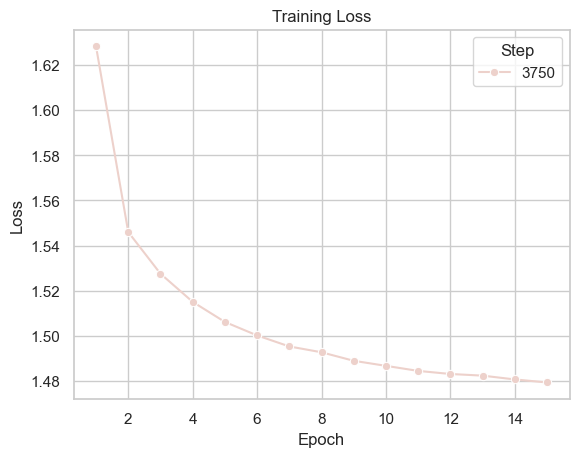

In [22]:
training_records_path = os.path.join(checkpoint_dir, "training_records.csv")
training_records_df = pd.read_csv(training_records_path, index_col=0)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

sns.lineplot(x='epoch', y='loss', hue='step', data=training_records_df, errorbar=('ci', 100), marker='o')
plt.title(f'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Step')
plt.show()

In [37]:
# 使用训练好的模型进行预测
from PIL import Image
def predict_input(model, image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    img = Image.open(image_path)
    img = transform(img)
    img = img.unsqueeze(0)

    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item() - 1
    print(f"Predicted Label: {predicted_label}")

    img_show = img.squeeze(0).squeeze(0).numpy()
    plt.imshow(img_show, cmap='gray')
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.grid(False)
    plt.show()


Predicted Label: 6


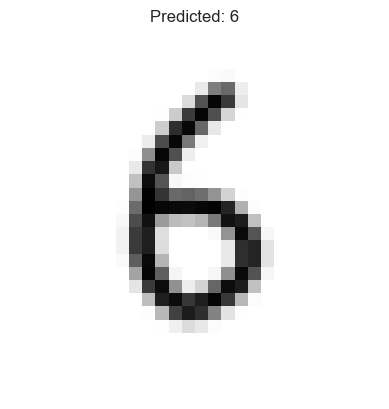

In [38]:
model_path = "./bestmodel-ckpt/checkpoint_epoch15_step3750.pth"
model = MediumNN()
model.load_state_dict(torch.load(model_path))
model.eval()

predict_input(model, './input/6.jpg')

Predicted Label: 4


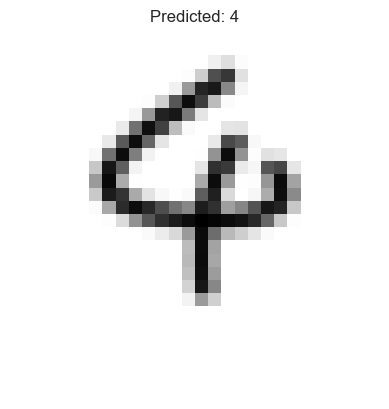

In [39]:
predict_input(model, './input/4.jpg')

## 数据分析

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# 不同的模型结构列表
models = [SimpleNN, MediumNN, ComplexNN]
# 超参数范围
learning_rates = [0.0001, 0.001, 0.01, 0.1]
num_epochs_list = [2, 5, 10, 15]
batch_sizes = [16, 32, 64, 128]

df = pd.read_csv('results.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     192 non-null    int64  
 1   model          192 non-null    object 
 2   learning_rate  192 non-null    float64
 3   num_epoch      192 non-null    int64  
 4   batch_size     192 non-null    int64  
 5   accuracy       192 non-null    float64
 6   precision      192 non-null    float64
 7   recall         192 non-null    float64
 8   f1_score       192 non-null    float64
 9   loss           192 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 15.1+ KB


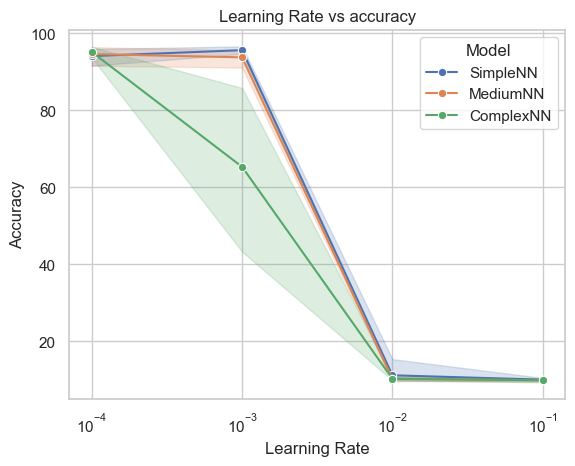

In [44]:
sns.lineplot(x='learning_rate', y='accuracy', hue='model', data=df, errorbar=('ci', 100), marker='o')
plt.title(f'Learning Rate vs accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(title='Model')
plt.show()

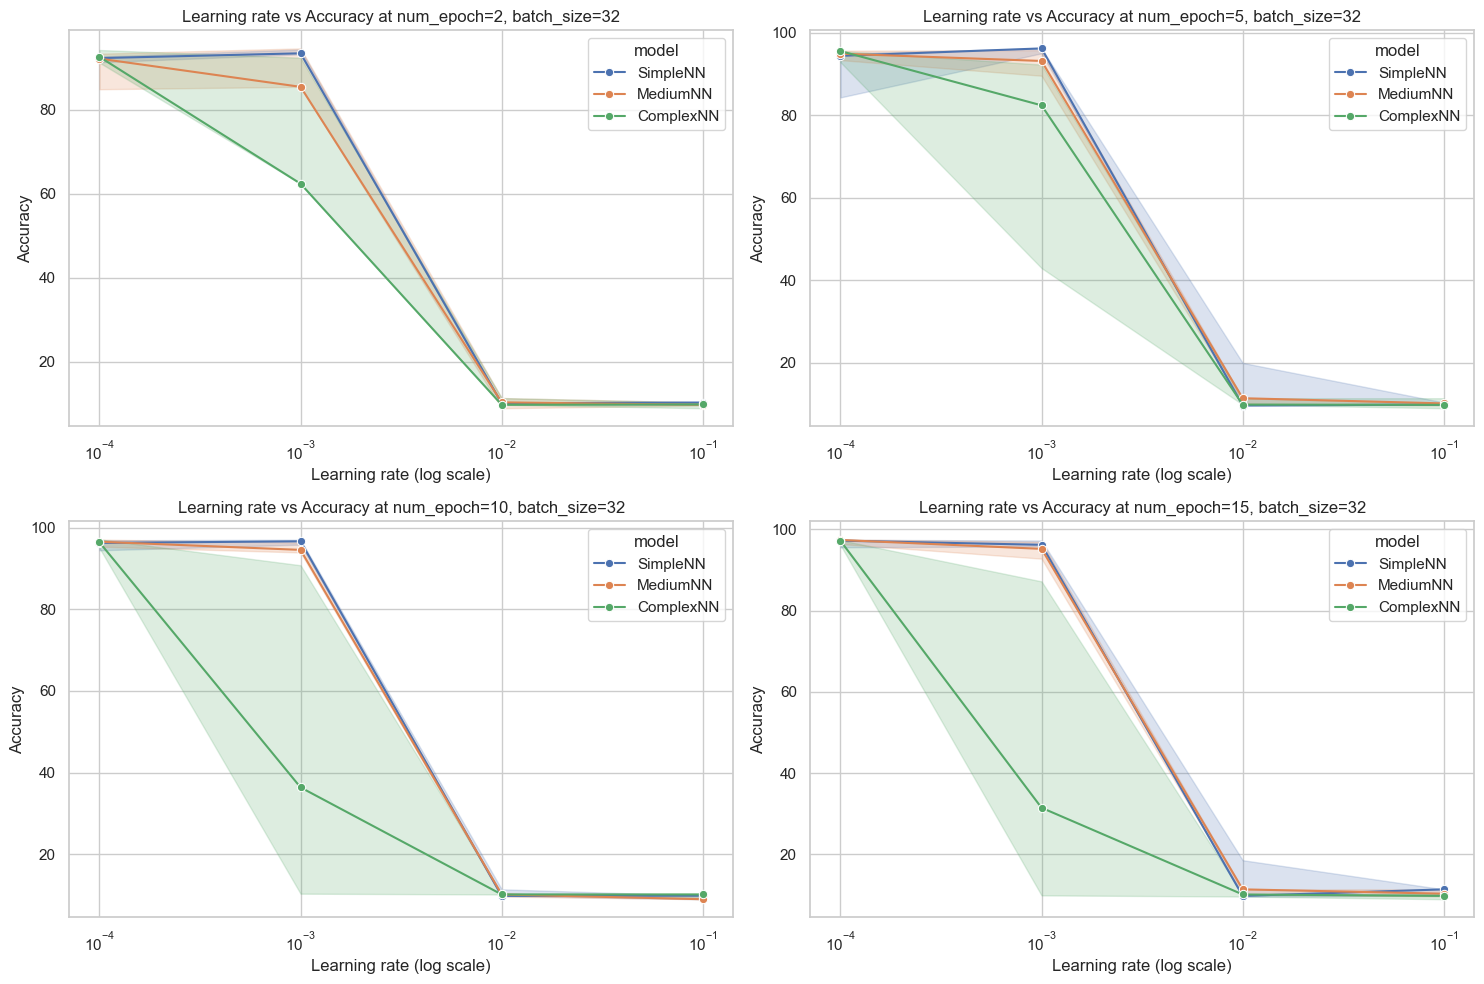

In [45]:
plt.figure(figsize=(15, 10))
for i, num in enumerate(num_epochs_list, 1):
    plt.subplot(2, 2, i)
    subset = df[df["num_epoch"] == num]
    sns.lineplot(
        x='learning_rate', 
        y='accuracy', 
        hue='model',
        data=subset,
        errorbar=('ci', 100),
        marker='',
        linestyle='',
        legend=False
    )
    sns.lineplot(
        x='learning_rate', 
        y='accuracy', 
        hue='model',
        data=subset[subset["batch_size"] == 32],
        marker='o',
        linestyle='-',
    )
    
    plt.title(f'Learning rate vs Accuracy at num_epoch={num}, batch_size=32')
    plt.xscale('log')
    plt.xlabel('Learning rate (log scale)')
    plt.ylabel('Accuracy')
    
plt.tight_layout()
plt.show()

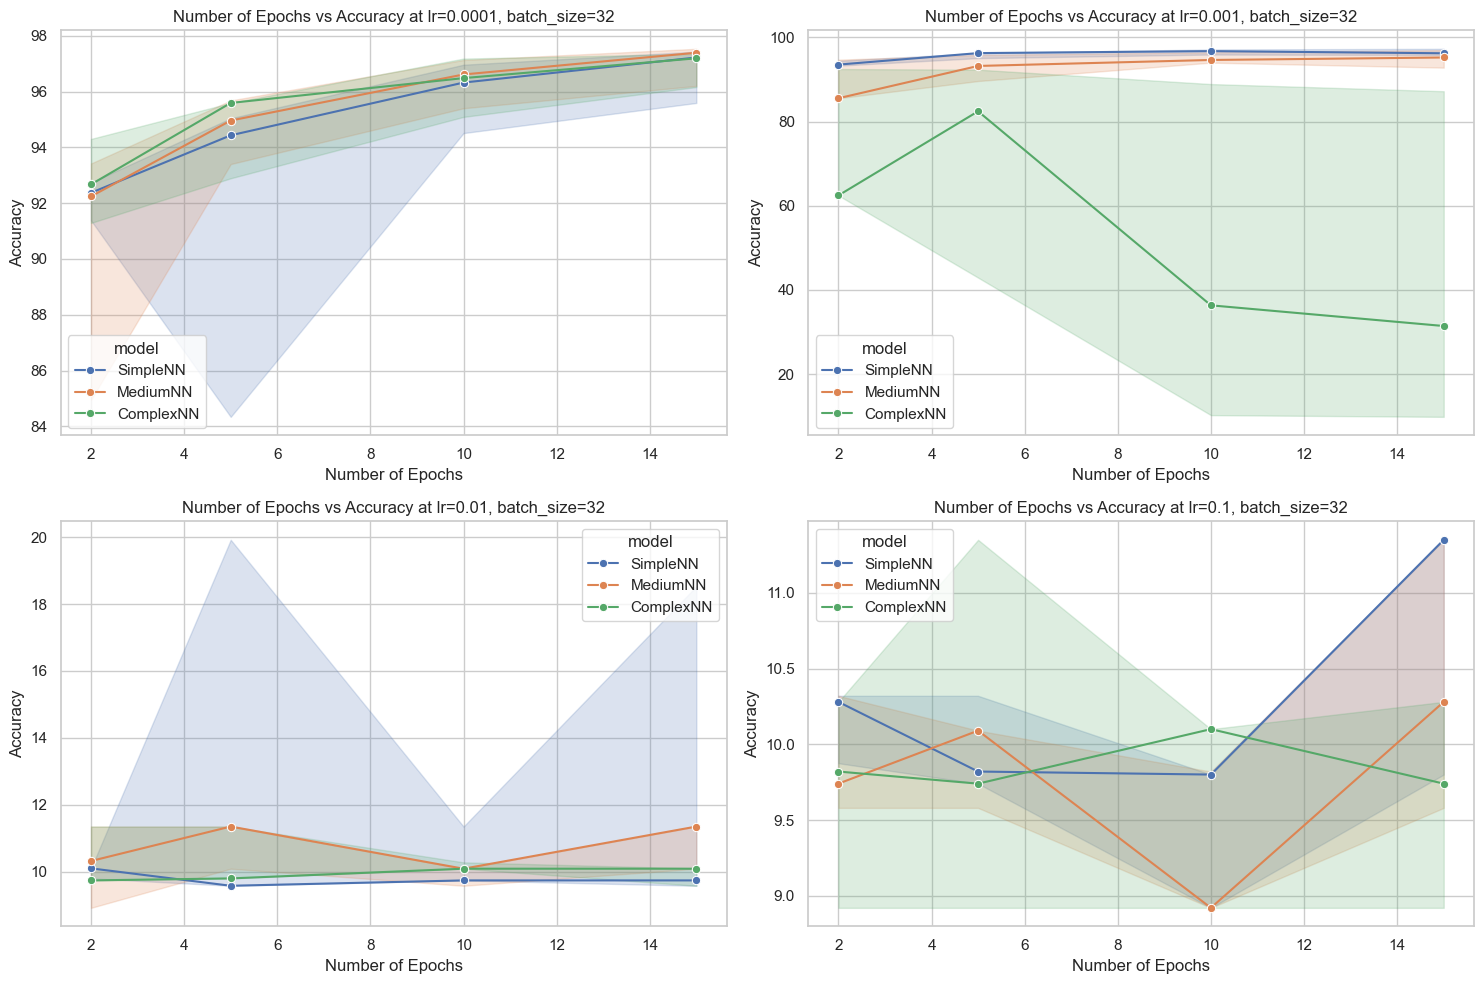

In [46]:
plt.figure(figsize=(15, 10))
for i, lr in enumerate(learning_rates, 1):
    plt.subplot(2, 2, i)
    subset = df[df["learning_rate"] == lr]
    sns.lineplot(
        x='num_epoch', 
        y='accuracy', 
        hue='model',
        data=subset,
        errorbar=('ci', 100),
        marker='',
        linestyle='',
        legend=False
    )
    sns.lineplot(
        x='num_epoch', 
        y='accuracy', 
        hue='model',
        data=subset[subset["batch_size"] == 32],
        marker='o',
        linestyle='-',
    )
    
    plt.title(f'Number of Epochs vs Accuracy at lr={lr}, batch_size=32')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    
plt.tight_layout()
plt.show()

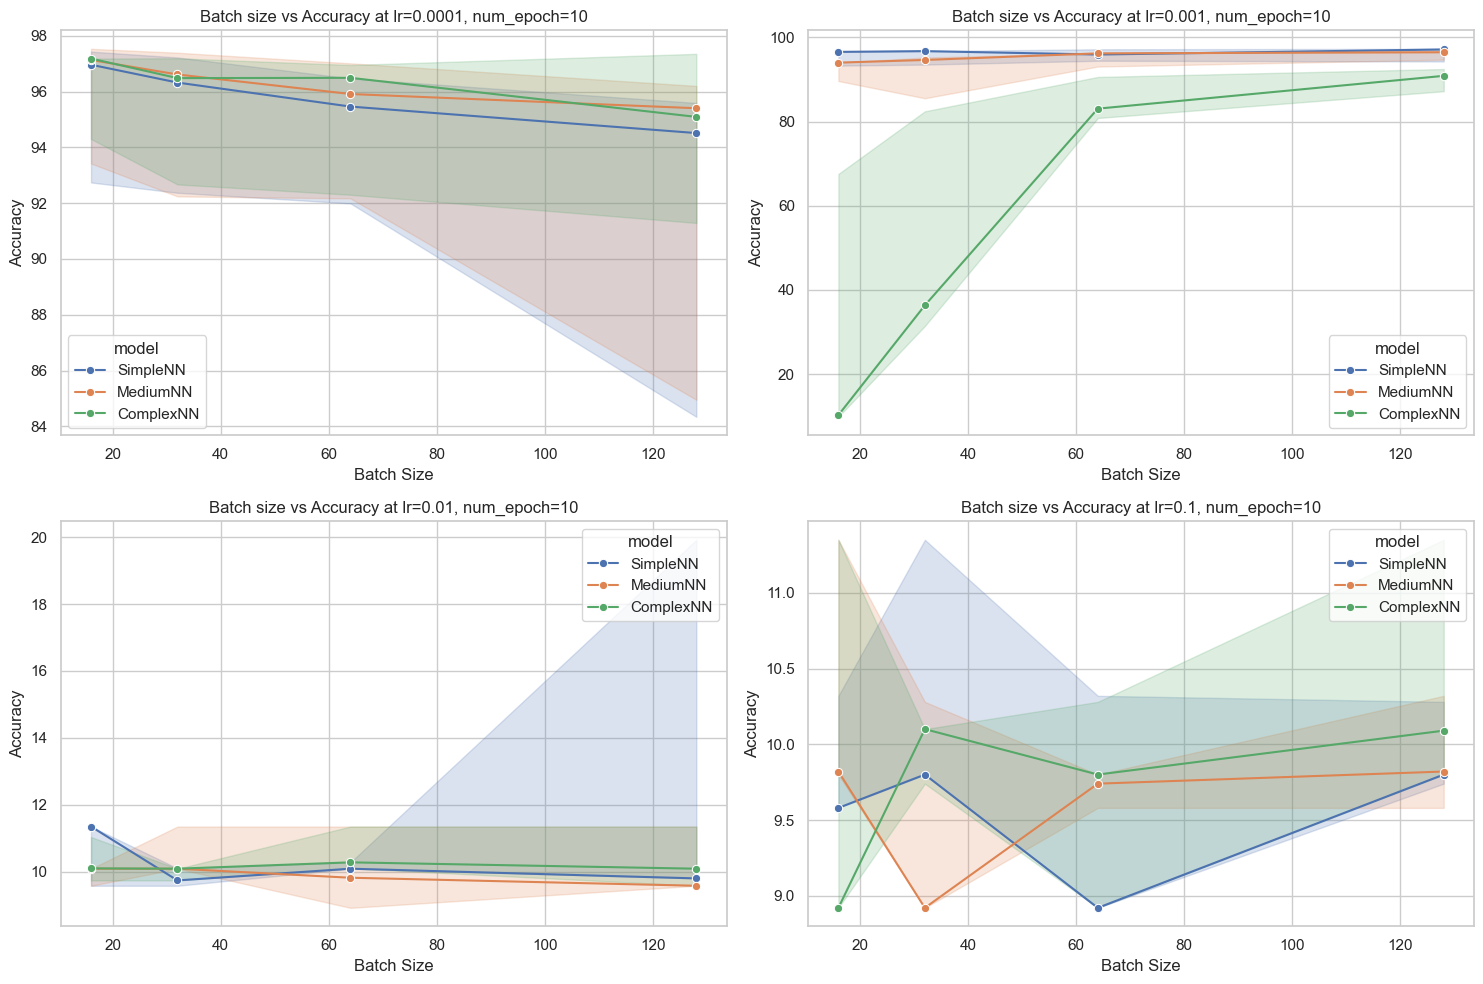

In [47]:
plt.figure(figsize=(15, 10))
for i, lr in enumerate(learning_rates, 1):
    plt.subplot(2, 2, i)
    subset = df[df["learning_rate"] == lr]
    sns.lineplot(
        x='batch_size', 
        y='accuracy', 
        hue='model',
        data=subset,
        errorbar=('ci', 100),
        marker='',
        linestyle='',
        legend=False
    )
    sns.lineplot(
        x='batch_size', 
        y='accuracy', 
        hue='model',
        data=subset[subset["num_epoch"] == 10],
        marker='o',
        linestyle='-',
    )
    
    plt.title(f'Batch size vs Accuracy at lr={lr}, num_epoch=10')
    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy')
    
plt.tight_layout()
plt.show()

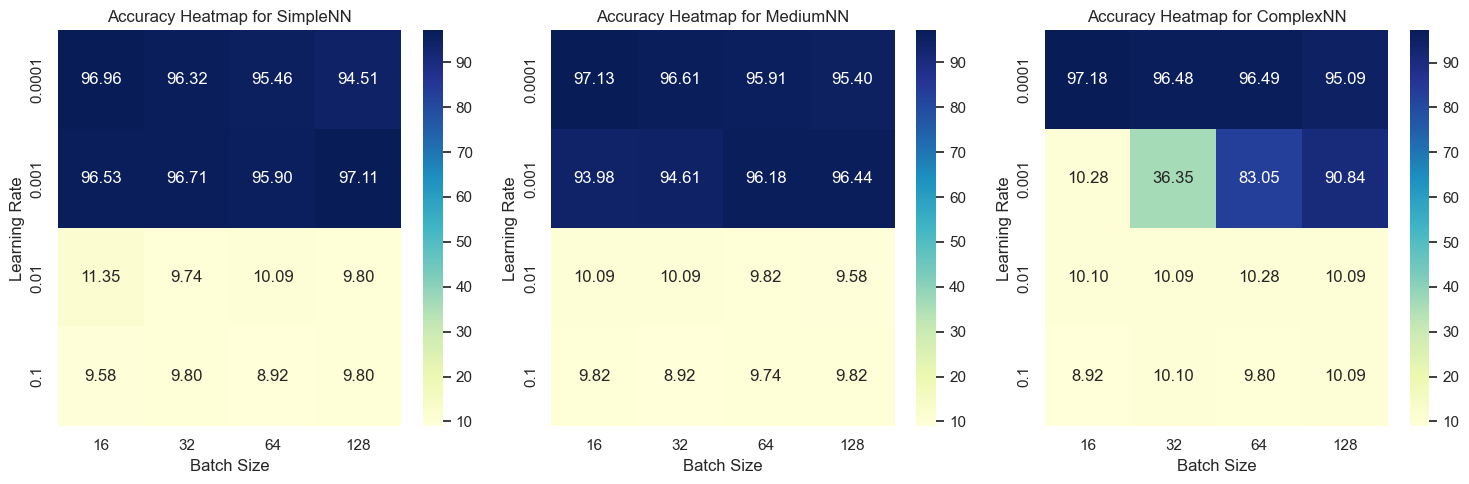

In [48]:
plt.figure(figsize=(15, 5))
for i, model in enumerate(models, 1):
    model_df = df[(df['model'] == f"{model.__name__}") & (df['num_epoch'] == 10)]
    pivot_table = model_df.pivot_table(
        values='accuracy', 
        index='learning_rate', 
        columns='batch_size'
    )
    plt.subplot(1, 3, i)
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title(f'Accuracy Heatmap for {model.__name__}')
    plt.ylabel('Learning Rate')
    plt.xlabel('Batch Size')
plt.tight_layout()
plt.show()

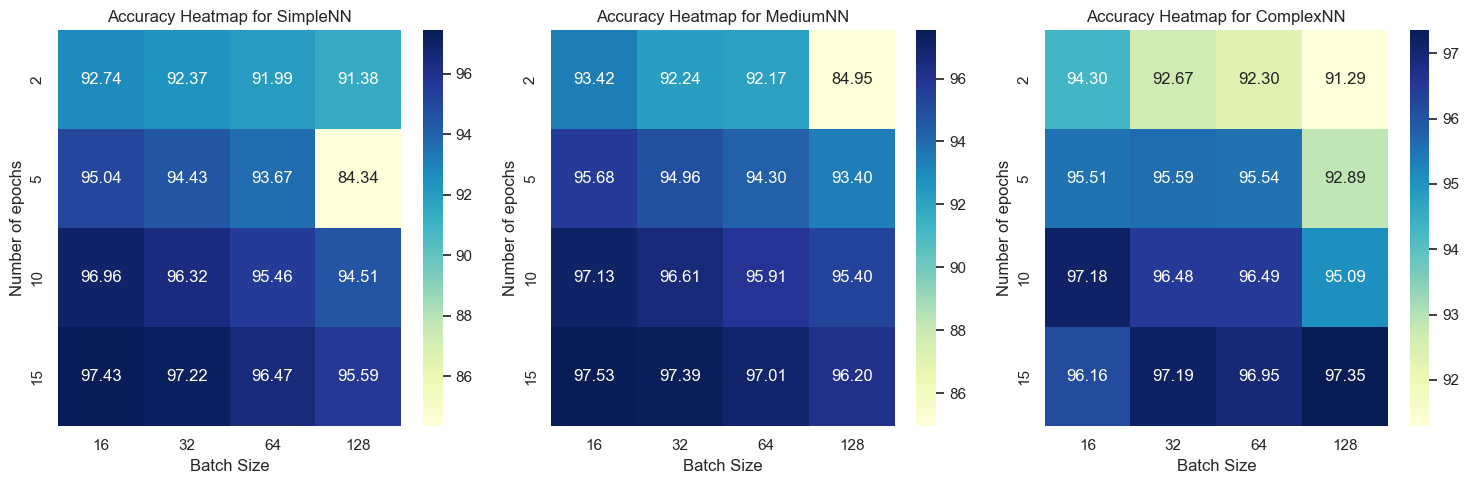

In [7]:
plt.figure(figsize=(15, 5))
for i, model in enumerate(models, 1):
    model_df = df[(df['model'] == f"{model.__name__}") & (df['learning_rate'] == 0.0001)]
    pivot_table = model_df.pivot_table(
        values='accuracy', 
        index='num_epoch', 
        columns='batch_size'
    )
    plt.subplot(1, 3, i)
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title(f'Accuracy Heatmap for {model.__name__}')
    plt.ylabel('Number of epochs')
    plt.xlabel('Batch Size')
plt.tight_layout()
plt.show()

## CNN

In [41]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
# 检查点保存目录
checkpoint_dir = "./cnnmodel-ckpt"
os.makedirs(checkpoint_dir, exist_ok=True)

# 设置保存间隔
save_checkpoint_steps = 1875
keep_checkpoint_max = 10
saved_checkpoints = []

model = CNNModel()
train_model(model=model, lr=0.001, num_epoch=15, batch_size=32, save=True)

Started training with model=CNNModel, lr=0.001, num_epoch=15, batch_size=32
Checkpoint saved at step 1875 for epoch 1
Epoch [1/15], Loss: 0.1179, Time: 19.11s
Checkpoint saved at step 1875 for epoch 2
Epoch [2/15], Loss: 0.0407, Time: 18.61s
Checkpoint saved at step 1875 for epoch 3
Epoch [3/15], Loss: 0.0291, Time: 18.56s
Checkpoint saved at step 1875 for epoch 4
Epoch [4/15], Loss: 0.0212, Time: 18.44s
Checkpoint saved at step 1875 for epoch 5
Epoch [5/15], Loss: 0.0172, Time: 18.54s
Checkpoint saved at step 1875 for epoch 6
Epoch [6/15], Loss: 0.0153, Time: 18.53s
Checkpoint saved at step 1875 for epoch 7
Epoch [7/15], Loss: 0.0124, Time: 18.55s
Checkpoint saved at step 1875 for epoch 8
Epoch [8/15], Loss: 0.0108, Time: 18.50s
Checkpoint saved at step 1875 for epoch 9
Epoch [9/15], Loss: 0.0130, Time: 18.58s
Checkpoint saved at step 1875 for epoch 10
Epoch [10/15], Loss: 0.0076, Time: 18.49s
Checkpoint saved at step 1875 for epoch 11
Epoch [11/15], Loss: 0.0084, Time: 18.57s
Checkpo

(99.18, 0.991830596610275, 0.9918, 0.9918001698623707, 0.007807245903536195)

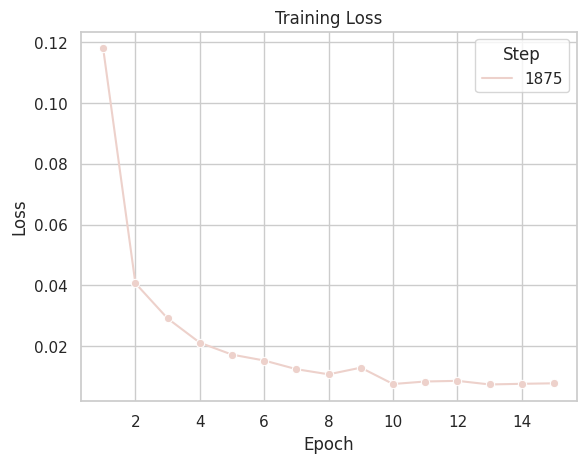

In [43]:
training_records_path = os.path.join(checkpoint_dir, "training_records.csv")
training_records_df = pd.read_csv(training_records_path, index_col=0)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

sns.lineplot(x='epoch', y='loss', hue='step', data=training_records_df, errorbar=('ci', 100), marker='o')
plt.title(f'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Step')
plt.show()